# Introduction:
Biomedical data is becoming increasingly complex, and capturing the underlying intricate, non-linear relationships poses significant challenges.

Deep learning offers the ability to construct generative models, such as variational autoencoders (VAEs), which incorporate multimodality and generative properties.

**Multimodality:** One of the key features of this approach is the ability to process and integrate multiple types of data through various layers of neural networks.

# Approach:
Our primary approach aims to capture the non-linear relationships between RNA and proteins. We seek to understand the underlying features of both types of data and generate one type from the other using a two-layer (multimodal) encoder-decoder architecture.

# Results
**Findings:** Located at the end of the notebook

**Figures:**  Located at the end of the notebook

# Conclusion
Deep learning is a vast field that encompasses multiple concepts and genres of algorithms, all of which can address this problem effectively. Generative models such as VAEs and GANs are particularly powerful tools that can reconstruct different types of biological data, including RNA and proteins, with greater accuracy. These modalities have the potential to bring about significant breakthroughs in biological research.

In our case, our model was able to predict/generate ADT from RNA better than it was able to generate RNA from ADT. The model struggled to learn when generating RNA data from ADT. Given this outcome, the model needs to be improved and our architecture needs to be revised to ensure our model can learn better to generate RNA given ADT and vice versa.

### Data Loading and Preprocessing

In [ ]:
# import necessary python documents

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
training_adt = pd.read_csv('train_ADT.csv').T.to_numpy()
training_rna = pd.read_csv('train_RNA.csv').T.to_numpy()
test_rna = pd.read_csv('test_rna.csv').T.to_numpy()
eval_rna = pd.read_csv('eval_RNA.csv').T.to_numpy()
eval_adt = pd.read_csv('eval_ADT.csv').T.to_numpy()

## Functions

### Defining Functions: Data Split

Defining the function that will split the data (80:20) randomly with a set seed. This allows us to train on 80% of the data and test on 20% and have deterministic data.

In [ ]:
def split_datasets(dataset1, dataset2, test_size=0.2, random_state=42):
    indices = np.arange(len(dataset1))

    idx_train, idx_test = train_test_split(
        indices,
        test_size=test_size,
        random_state=random_state
    )

    X1_train = dataset1[idx_train]
    X1_test = dataset1[idx_test]
    X2_train = dataset2[idx_train]
    X2_test = dataset2[idx_test]

    return X1_train, X1_test, X2_train, X2_test

adt_train, adt_test, rna_train, rna_test = split_datasets(training_adt, training_rna)

# Print shapes to verify the split
print("ADT Training set shape:", adt_train.shape)
print("ADT Test set shape:", adt_test.shape)
print("RNA Training set shape:", rna_train.shape)
print("RNA Test set shape:", rna_test.shape)

### Defining Weights & Biases functions

Initialize the weights randomly using He initialization so that the variance of the outputs remains stable.

In [ ]:
def initialise_weight(in_channel, out_channel):
    W = np.random.randn(in_channel, out_channel).astype(np.float32) * np.sqrt(2.0/(in_channel))
    return W


def initialise_bias(out_channel):
    b = np.zeros((1, out_channel))
    return b

## Class Creation

### Class Creation: Forward & Backward Pass

Below is the fully connected neural network including forward pass and back propagation. The class includes functions that retrieves the weights & biases and updates the weights and biases when training.

In [ ]:
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        self.weights = initialise_weight(n_inputs, n_neurons)
        self.biases = initialise_bias(n_neurons)

    # Forward pass
    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

    # Retrieve layer parameters
    def get_parameters(self):
        return self.weights, self.biases

    # Set weights and biases in a layer instance
    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases


### Class Creation: Dropout Regularization

Dropout regularization is applied to prevent overfitting. It is done by randomly deactivating the neurons which forces the network to learn more generalized features. During backward pass, a mask ensures gradients are propagated through active neurons as well.

In [ ]:
class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate

    def forward(self, inputs, training):
        self.inputs = inputs

        if not training:
            self.output = inputs.copy()
            return

        self.binary_mask = np.random.binomial(1, self.rate,
                           size=inputs.shape) / self.rate
        self.output = inputs * self.binary_mask

    def backward(self, dvalues):
        # self.print_shape()
        self.dinputs = dvalues * self.binary_mask

### Class Creation: Layer Input

The layer input class below serves as our input layer for the model with a feed forward method to pass the inputs forward.

In [ ]:
class Layer_Input:
    def forward(self, inputs, training):
        self.output = inputs

### Class Creation: Activation Function (ReLU)

We used ReLU activation function to induce non-linearity so that the model can understand the complex underlying structure. It also helps create sparsity which can help prevent overfitting.

In [ ]:
class Activation_ReLU:

    def forward(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

    def predictions(self, outputs):
        return outputs

### Class Creation: Adam Optimization

For optimization, we use Adam which ensures efficient updates of weights and biases. In this class, we have a learning rate that is adjusted using a given decay factor. Momentum and Root Mean Spuare Propagation (RMSprop) estimates help to accelerate convergence. Momentum is represented by beta_1 to determine how much weight is given to the past gradients, and RMSprop is represented by beta_2 controls the decay rate for the moving average of the squared gradient.

In [ ]:
class Optimizer_Adam:

    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):

        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)


        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)

    def post_update_params(self):
        self.iterations += 1


### Class Creation: Loss Function

The loss class calculates and tracks losses during training for a single batch. During training, the class accumulates losses over multiple batches, then resets during a new epoch

In [ ]:
class Loss:
    def calculate(self, output, y):

        sample_losses = self.forward(output, y)

        data_loss = np.mean(sample_losses)

        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        return data_loss

    def calculate_accumulated(self):
        data_loss = self.accumulated_sum / self.accumulated_count
        return data_loss

    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0


### Class Creation: MSE Calculation

The loss class above provides the framework that is used in the class below to calculate the mean squared error loss between the predicted values and the target values. The class also calculates the gradient which updates the parameters during backpropagation.

In [ ]:
class Loss_MeanSquaredError(Loss):  # L2 loss

    # Forward pass
    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


### Class Creation: Model Architecture

Various lists are initialized to store differnt network layers including seperate encoder decoder and shared encoder decoder.
We are training the model, feeding RNA and ADT in a way that it learns the underlying structure of each data and tries to generate one from the other. Once trained, the model takes new RNA information and predicts ADT.

The class will add encoder layers depending on whether the input is RNA or ADT, allowing us to process the inputs separately. Below, we shall highlight some functions within the class.

The **train function** takes the training data, validation data, epochs and batch size. It uses the number of epochs and batch to loop through the inputs then performs a forward pass for RNA and ADT. Loss is then calculated  and used during backward pass to update the parameters.

The **predict function** allows the model to generate predictions on unseen data. It creates a new list to store predictions, then loops through using the batch size before performing a forward pass to the given layer (either RNA or ADT). The stored predictions are then used to calculate loss and accuracy for given the expected values.

The **evaluation function** is used to assess the model's performance and it takes the validation data as input. In this function, we calculate the loss for RNA and ADT predictions. We do not train the model on this data which is specified in the function. This allows us to avoid fitting our model to the evaluation data set which would lead to false results when we test our predictions against the evaluations.



In [ ]:
#Initialization:
class Model:
    def __init__(self):
        # Create a list of network objects
        self.enc_rna_layers = []
        self.enc_adt_layers = []
        self.enc_s_layers = []
        self.dec_s_layers = []
        self.dec_rna_layers = []
        self.dec_adt_layers = []

        self.rna_trainable_layers = []
        self.adt_trainable_layers = []

        self.per_epoch_rna_loss = []
        self.per_epoch_adt_loss = []
        self.per_epoch_validation_rna_loss = []
        self.per_epoch_validation_adt_loss = []
        self.per_epoch_adt_eval_loss = []
        self.per_epoch_rna_eval_loss = []

        # Softmax classifier's output object

    # Adding layers
    def add(self, layer, type):
        if type == 'enc_rna':
            self.enc_rna_layers.append(layer)
        elif type == 'enc_adt':
            self.enc_adt_layers.append(layer)
        elif type == 'enc_s':
            self.enc_s_layers.append(layer)
        elif type == 'dec_s':
            self.dec_s_layers.append(layer)
        elif type == 'dec_rna':
            self.dec_rna_layers.append(layer)
        elif type == 'dec_adt':
            self.dec_adt_layers.append(layer)

    # Set loss, optimizer and accuracy
    def set(self, rna_loss=None, adt_loss=None, optimizer=None):
        if rna_loss is not None:
            self.rna_loss = rna_loss

        if adt_loss is not None:
            self.adt_loss = adt_loss

        if optimizer is not None:
            self.optimizer = optimizer

    # Finalize the model
    def finalize(self):

        self.input_rna_layer = Layer_Input()
        self.input_adt_layer = Layer_Input()

        enc_rna_layer_count = len(self.enc_rna_layers)
        enc_adt_layer_count = len(self.enc_adt_layers)
        enc_s_layer_count = len(self.enc_s_layers)
        dec_s_layer_count = len(self.dec_s_layers)
        dec_adt_layer_count = len(self.dec_adt_layers)
        dec_rna_layer_count = len(self.dec_rna_layers)


        # Iterate the objects
        for i in range(enc_rna_layer_count):
            if i == 0:
                self.enc_rna_layers[i].prev = self.input_rna_layer
                self.enc_rna_layers[i].next = self.enc_rna_layers[i+1]

            elif i < enc_rna_layer_count - 1:
                self.enc_rna_layers[i].prev = self.enc_rna_layers[i-1]
                self.enc_rna_layers[i].next = self.enc_rna_layers[i+1]

            else:
                self.enc_rna_layers[i].prev = self.enc_rna_layers[i-1]
                self.enc_rna_layers[i].next = self.enc_s_layers[0]

            if hasattr(self.enc_rna_layers[i], 'weights'):
                self.rna_trainable_layers.append(self.enc_rna_layers[i])


        for i in range(enc_adt_layer_count):
            if i == 0:
                self.enc_adt_layers[i].prev = self.input_adt_layer
                self.enc_adt_layers[i].next = self.enc_adt_layers[i+1]
            elif i < enc_rna_layer_count - 1:
                self.enc_adt_layers[i].prev = self.enc_adt_layers[i-1]
                self.enc_adt_layers[i].next = self.enc_adt_layers[i+1]
            else:
                self.enc_adt_layers[i].prev = self.enc_adt_layers[i-1]
                self.enc_adt_layers[i].next = self.enc_s_layers[0]

            if hasattr(self.enc_adt_layers[i], 'weights'):
                self.adt_trainable_layers.append(self.enc_adt_layers[i])

        for i in range(enc_s_layer_count):
            if i == 0:
                self.enc_s_layers[0].prev_rna_layer = self.enc_rna_layers[enc_rna_layer_count-1]
                self.enc_s_layers[0].prev_adt_layer = self.enc_adt_layers[enc_adt_layer_count-1]
                self.enc_s_layers[i].next = self.enc_s_layers[i+1]
            elif i < enc_s_layer_count - 1:
                self.enc_s_layers[i].prev = self.enc_s_layers[i-1]
                self.enc_s_layers[i].next = self.enc_s_layers[i+1]
            else:
                self.enc_s_layers[i].prev = self.enc_s_layers[i-1]
                self.enc_s_layers[i].next = self.dec_s_layers[0]

            if hasattr(self.enc_s_layers[i], 'weights'):
                self.rna_trainable_layers.append(self.enc_s_layers[i])
                self.adt_trainable_layers.append(self.enc_s_layers[i])


        for i in range(dec_s_layer_count):
            if i == 0:
                self.dec_s_layers[0].prev = self.enc_s_layers[enc_s_layer_count-1]
                self.dec_s_layers[i].next = self.dec_s_layers[i+1]
            elif i < enc_s_layer_count - 1:
                self.dec_s_layers[i].prev = self.dec_s_layers[i-1]
                self.dec_s_layers[i].next = self.dec_s_layers[i+1]
            else:
                self.dec_s_layers[i].prev = self.dec_s_layers[i-1]
                self.dec_s_layers[i].next_rna_layer = self.dec_rna_layers[0]
                self.dec_s_layers[i].next_adt_layer = self.dec_adt_layers[0]

            if hasattr(self.dec_s_layers[i], 'weights'):
                self.rna_trainable_layers.append(self.dec_s_layers[i])
                self.adt_trainable_layers.append(self.dec_s_layers[i])

        for i in range(dec_rna_layer_count):
            if i == 0:
                self.dec_rna_layers[i].prev = self.dec_s_layers[dec_s_layer_count-1]
                self.dec_rna_layers[i].next = self.dec_rna_layers[i+1]

            elif i < dec_rna_layer_count - 1:
                self.dec_rna_layers[i].prev = self.dec_rna_layers[i-1]
                self.dec_rna_layers[i].next = self.dec_rna_layers[i+1]

            else:
                self.dec_rna_layers[i].prev = self.dec_rna_layers[i-1]
                self.dec_rna_layers[i].next = self.rna_loss
                self.output_layer_activation = self.dec_rna_layers[i]

            if hasattr(self.dec_rna_layers[i], 'weights'):
                self.rna_trainable_layers.append(self.dec_rna_layers[i])

        for i in range(dec_adt_layer_count):
            if i == 0:
                self.dec_adt_layers[i].prev = self.dec_s_layers[dec_s_layer_count-1]
                self.dec_adt_layers[i].next = self.dec_adt_layers[i+1]

            elif i < dec_adt_layer_count - 1:
                self.dec_adt_layers[i].prev = self.dec_adt_layers[i-1]
                self.dec_adt_layers[i].next = self.dec_adt_layers[i+1]

            else:
                self.dec_adt_layers[i].prev = self.dec_adt_layers[i-1]
                self.dec_adt_layers[i].next = self.adt_loss
                self.output_layer_activation = self.dec_adt_layers[i]

            if hasattr(self.dec_adt_layers[i], 'weights'):
                self.adt_trainable_layers.append(self.dec_adt_layers[i])

#Forward pass
    def forward(self, X_adt, X_rna, training, mode = 'rna'):
        if mode == 'rna':
            self.input_rna_layer.forward(X_rna, training)
            for layer in self.enc_rna_layers:
                layer.forward(layer.prev.output, training)
            for layer in self.enc_s_layers:
                if hasattr(layer, 'prev_rna_layer'):
                    layer.forward(layer.prev_rna_layer.output, training)
                else:
                    layer.forward(layer.prev.output, training)
            for layer in self.dec_s_layers:
                layer.forward(layer.prev.output, training)
            for layer in self.dec_rna_layers:
                layer.forward(layer.prev.output, training)

        elif mode == 'adt':
            self.input_adt_layer.forward(X_adt, training)
            for layer in self.enc_adt_layers:
                layer.forward(layer.prev.output, training)
            for layer in self.enc_s_layers:
                if hasattr(layer, 'prev_adt_layer'):
                    layer.forward(layer.prev_adt_layer.output, training)
                else:
                    layer.forward(layer.prev.output, training)
            for layer in self.dec_s_layers:
                layer.forward(layer.prev.output, training)
            for layer in self.dec_adt_layers:
                layer.forward(layer.prev.output, training)

        return layer.output

#Backward pass
    def backward(self, output, y_adt, y_rna, mode = 'rna'):
        if mode == 'rna':
            self.rna_loss.backward(output, y_rna)
            for layer in reversed(self.dec_rna_layers):
                layer.backward(layer.next.dinputs)
            for layer in reversed(self.dec_s_layers):
                if hasattr(layer, 'next_rna_layer'):
                    layer.backward(layer.next_rna_layer.dinputs)
                else:
                    layer.backward(layer.next.dinputs)
            for layer in reversed(self.enc_s_layers):
                layer.backward(layer.next.dinputs)
            for layer in reversed(self.enc_rna_layers):
                layer.backward(layer.next.dinputs)

        if mode == 'adt':
            self.adt_loss.backward(output, y_adt)
            for layer in reversed(self.dec_adt_layers):
                layer.backward(layer.next.dinputs)

            for layer in reversed(self.dec_s_layers):
                if hasattr(layer, 'next_adt_layer'):
                    layer.backward(layer.next_adt_layer.dinputs)
                else:
                    layer.backward(layer.next.dinputs)
            for layer in reversed(self.enc_s_layers):
                layer.backward(layer.next.dinputs)
            for layer in reversed(self.enc_adt_layers):
                layer.backward(layer.next.dinputs)
                # layer.print_shape()

#Training Loop
    def train(self, X_rna, X_adt, validation_rna=None, validation_adt=None, epochs=20, batch_size=64,
              print_every=30):

        train_steps = 1

        if batch_size is not None:
            train_steps = len(X_rna) // batch_size
            if train_steps * batch_size < len(X_rna):
                train_steps += 1


        # Main training loop
        for epoch in range(1, epochs+1):

            # Print epoch number
            print(f'epoch: {epoch}')

            self.rna_loss.new_pass()
            self.adt_loss.new_pass()

            # Iterate over steps
            for step in range(train_steps):

                # If batch size is not set -
                # train using one step and full dataset
                if batch_size is None:
                    batch_X_adt = X_adt
                    batch_y_adt = X_adt
                    batch_X_rna = X_rna
                    batch_y_rna = X_rna

                # Otherwise slice a batch
                else:
                    batch_X_adt = X_adt[step*batch_size:(step+1)*batch_size]
                    batch_y_adt = X_adt[step*batch_size:(step+1)*batch_size]
                    batch_X_rna = X_rna[step*batch_size:(step+1)*batch_size]
                    batch_y_rna = X_rna[step*batch_size:(step+1)*batch_size]

                # Perform the forward pass for rna
                output = self.forward(batch_X_adt, batch_X_rna, training=True, mode = 'rna')

                # Calculate loss
                rna_data_loss = self.rna_loss.calculate(output, batch_y_rna)
                # loss = rna_data_loss

                # Get predictions for R2 score
                predictions = self.output_layer_activation.predictions(
                                  output)


                # Perform backward pass for rna
                self.backward(output, batch_y_adt, batch_y_rna, mode = 'rna')

                # Optimize (update parameters)
                self.optimizer.pre_update_params()

                for layer in self.rna_trainable_layers:
                    self.optimizer.update_params(layer)


                # Perform the forward pass for adt
                output = self.forward(batch_X_adt, batch_X_rna, training=True, mode = 'adt')

                adt_data_loss = self.adt_loss.calculate(output, batch_y_adt)
                # loss = adt_data_loss

                predictions = self.output_layer_activation.predictions(
                                  output)

                self.backward(output, batch_y_adt, batch_y_rna, mode = 'adt')

                for layer in self.adt_trainable_layers:
                    self.optimizer.update_params(layer)


                self.optimizer.post_update_params()

                # Print a summary
                if not step % print_every or step == train_steps - 1:
                    print(f'step: {step}, ' +
                          f'rna_loss: {rna_data_loss:.3f}, ' +
                          f'adt_loss: {adt_data_loss:.3f}, ' +
                          f'lr: {self.optimizer.current_learning_rate}')

            # Get and print epoch loss and accuracy
            epoch_rna_data_loss = \
                self.rna_loss.calculate_accumulated()

            epoch_adt_data_loss = \
                self.adt_loss.calculate_accumulated()

            epoch_loss = epoch_adt_data_loss + epoch_rna_data_loss

            self.per_epoch_rna_loss.append(epoch_rna_data_loss)
            self.per_epoch_adt_loss.append(epoch_adt_data_loss)

            print(f'training, ' +
                  f'loss: {epoch_loss:.3f} (' +
                  f'rna_data_loss: {epoch_rna_data_loss:.3f}, ' +
                  f'adt_data_loss: {epoch_adt_data_loss:.3f}, ' +
                  f'lr: {self.optimizer.current_learning_rate})')

            self.evaluate(validation_rna, validation_adt)
#Evaluation
    def evaluate(self, validation_rna, validation_adt):
        self.rna_loss.new_pass()
        self.adt_loss.new_pass()

        batch_X_adt = validation_adt
        batch_y_adt = validation_adt
        batch_X_rna = validation_rna
        batch_y_rna = validation_rna

        output = self.forward(batch_X_adt, batch_X_rna, training=False, mode = 'rna')
        rna_data_loss = self.rna_loss.calculate(output, batch_y_rna)

        output = self.forward(batch_X_adt, batch_X_rna, training=False, mode = 'adt')
        adt_data_loss = self.adt_loss.calculate(output, batch_y_adt)

        validation_rna_data_loss = self.rna_loss.calculate_accumulated()
        validation_adt_data_loss = self.adt_loss.calculate_accumulated()

        self.per_epoch_validation_rna_loss.append(validation_rna_data_loss)
        self.per_epoch_validation_adt_loss.append(validation_adt_data_loss)

        print(f'Validation: ' +
                  f'validation_rna_data_loss: {validation_rna_data_loss:.3f}, ' +
                  f'validation_adt_data_loss: {validation_adt_data_loss:.3f} ')

        self.adt_loss.new_pass()
        self.rna_loss.new_pass()

        predicted_adt_data_from_eval = self.predict(eval_rna, eval_adt, 'adt', None)
        predicted_adt_data_from_eval_loss = self.adt_loss.calculate(predicted_adt_data_from_eval, eval_adt)
        self.per_epoch_adt_eval_loss.append(predicted_adt_data_from_eval_loss)

        print(f'Evaluation:' +
              f'Adt data loss from rna: {predicted_adt_data_from_eval_loss:.3f}')

        predicted_rna_data_from_eval = self.predict(eval_rna, eval_adt, 'rna', None)
        predicted_rna_data_from_eval_loss = self.rna_loss.calculate(predicted_rna_data_from_eval, eval_rna)
        self.per_epoch_rna_eval_loss.append(predicted_rna_data_from_eval_loss)

        print(f'Evaluation:' +
              f'RNA data loss from adt: {predicted_rna_data_from_eval_loss:.3f}')

#Prediction
    def predict(self, test_rna_transposed, test_adt_transposed = None, mode = 'adt', batch_size=None):

            # Default value if batch size is not being set
            if mode == 'adt':
                output = []

                # Iterate over step
                if batch_size is None:
                        batch_X = test_rna_transposed

                self.input_rna_layer.forward(batch_X, False)
                for layer in self.enc_rna_layers:
                    layer.forward(layer.prev.output, False)
                for layer in self.enc_s_layers:
                    if hasattr(layer, 'prev_rna_layer'):
                        layer.forward(layer.prev_rna_layer.output, False)
                    else:
                        layer.forward(layer.prev.output, False)
                for layer in self.dec_s_layers:
                    layer.forward(layer.prev.output, False)
                for layer in self.dec_adt_layers:
                    layer.forward(layer.prev.output, False)

                batch_output = layer.output
                output.append(batch_output)

                return np.vstack(output)

            elif mode == 'rna':
                output = []

                # Iterate over step
                if batch_size is None:
                        batch_X = test_adt_transposed

                self.input_adt_layer.forward(batch_X, False)
                for layer in self.enc_adt_layers:
                    layer.forward(layer.prev.output, False)
                for layer in self.enc_s_layers:
                    if hasattr(layer, 'prev_adt_layer'):
                        layer.forward(layer.prev_adt_layer.output, False)
                    else:
                        layer.forward(layer.prev.output, False)
                for layer in self.dec_s_layers:
                    layer.forward(layer.prev.output, False)
                for layer in self.dec_rna_layers:
                    layer.forward(layer.prev.output, False)

                batch_output = layer.output
                output.append(batch_output)

                return np.vstack(output)

## Model Implementation

Multiple feed forward neural network is created for each encoder and decoder for rna and adt, as well as the shared one. Each encoder consist of hidden layer, activation function, dropout layer that learns to compress the input rna and adt, which is then subjected to shared encoder-decoder after which  the decoder reconstructs them respectively.

A dropout rate is added after every layer.

Adam optimizer is used to reguralize and prevent the overfitting.


Loss is calculated separately for rna and adt.

In [ ]:
# 2nd arch

vae_model = Model()

#The RNA encoder processes the RNA input data
vae_model.add(Layer_Dense(10000, 1024),'enc_rna')
vae_model.add(Activation_ReLU(),'enc_rna')
vae_model.add(Layer_Dropout(0.2),'enc_rna')
vae_model.add(Layer_Dense(1024, 512),'enc_rna')
vae_model.add(Layer_Dropout(0.2),'enc_rna')
vae_model.add(Activation_ReLU(),'enc_rna')

#The ADT encoder processes the ADT input data
vae_model.add(Layer_Dense(25, 128),'enc_adt')
vae_model.add(Activation_ReLU(),'enc_adt')
vae_model.add(Layer_Dropout(0.2),'enc_adt')
vae_model.add(Layer_Dense(128, 256),'enc_adt')
# vae_model.add(Layer_Dropout(0.2),'enc_adt')
vae_model.add(Activation_ReLU(),'enc_adt')
vae_model.add(Layer_Dense(256, 512),'enc_adt')
vae_model.add(Layer_Dropout(0.2),'enc_adt')
vae_model.add(Activation_ReLU(),'enc_adt')

#The shared encoder and decoder layers create a common latent representation of the RNA and ADT data.
vae_model.add(Layer_Dense(512, 256),'enc_s')
vae_model.add(Activation_ReLU(),'enc_c')
vae_model.add(Layer_Dense(256, 128),'enc_s')
vae_model.add(Activation_ReLU(),'enc_s')

vae_model.add(Layer_Dense(128, 256),'dec_s')
vae_model.add(Activation_ReLU(),'dec_s')
vae_model.add(Layer_Dense(256, 512),'dec_s')
vae_model.add(Activation_ReLU(),'dec_s')

#The RNA decoder reconstructs the RNA data from the shared representation.
vae_model.add(Layer_Dense(512, 1024),'dec_rna')
vae_model.add(Activation_ReLU(),'dec_rna')
vae_model.add(Layer_Dropout(0.2),'dec_rna')
vae_model.add(Layer_Dense(1024, 10000),'dec_rna')
vae_model.add(Layer_Dropout(0.2),'dec_rna')
vae_model.add(Activation_ReLU(),'dec_rna')

#The ADT decoder reconstructs the ADT data from the shared representation
vae_model.add(Layer_Dense(512, 256),'dec_adt')
vae_model.add(Activation_ReLU(),'dec_adt')
vae_model.add(Layer_Dropout(0.2),'dec_adt')
vae_model.add(Layer_Dense(256, 128),'dec_adt')
vae_model.add(Activation_ReLU(),'dec_adt')
vae_model.add(Layer_Dropout(0.2),'dec_adt')
vae_model.add(Layer_Dense(128, 25),'dec_adt')
vae_model.add(Layer_Dropout(0.2),'dec_adt')
vae_model.add(Activation_ReLU(),'dec_adt')

#Setting Loss Functions and Optimizer
vae_model.set(
    rna_loss = Loss_MeanSquaredError(),
    adt_loss = Loss_MeanSquaredError(),
    optimizer = Optimizer_Adam( decay = 1e-3 ),
)

vae_model.finalize()

### Model Training

Initiating the training process for the VAE model, which reconstructs RNA and ADT as well as calculates the reconstruction error seperately for RNA and ADT.

In [ ]:
# adt_train, adt_test, rna_train, rna_test

vae_model.train(rna_train, adt_train, rna_test, adt_test, epochs=20, batch_size=64)

epoch: 1
step: 0, rna_loss: 2.029, adt_loss: 27.689, lr: 0.001
step: 30, rna_loss: 0.245, adt_loss: 6.636, lr: 0.0009708737864077671
step: 60, rna_loss: 0.239, adt_loss: 5.587, lr: 0.0009433962264150942
step: 62, rna_loss: 0.240, adt_loss: 5.059, lr: 0.0009416195856873823
training, loss: 7.943 (rna_data_loss: 0.302, adt_data_loss: 7.641, lr: 0.0009416195856873823)
Validation: validation_rna_data_loss: 0.207, validation_adt_data_loss: 2.970 
Evaluation:Adt data loss from rna: 11.735
Evaluation:RNA data loss from adt: 0.320
epoch: 2
step: 0, rna_loss: 0.240, adt_loss: 4.673, lr: 0.0009407337723424272
step: 30, rna_loss: 0.229, adt_loss: 4.691, lr: 0.0009149130832570906
step: 60, rna_loss: 0.227, adt_loss: 4.170, lr: 0.0008904719501335709
step: 62, rna_loss: 0.236, adt_loss: 4.676, lr: 0.0008888888888888888
training, loss: 5.007 (rna_data_loss: 0.230, adt_data_loss: 4.777, lr: 0.0008888888888888888)
Validation: validation_rna_data_loss: 0.198, validation_adt_data_loss: 2.171 
Evaluation:A

### Prediction: Results Generation

Prediction is generated for the RNA data, which is reshaped to appropriately to make submission in the kaggle.

In [ ]:
output = vae_model.predict(test_rna, None)
print(output.shape)

def create_submission_file(array_2d):
    # Ensure input array has correct shape
    assert array_2d.shape == (25, 5000), "Input array must have shape (25, 5000)"

    # Create ID column (row_1 to row_25000)
    id_column = [f'id{i+1}' for i in range(125000)]

    # Flatten the array in column-major order (Fortran-style)
    expected_column = array_2d.flatten('F')

    # Create DataFrame
    df = pd.DataFrame({
        'Id': id_column,
        'Expected': expected_column
    })

    # Save to CSV file
    df.to_csv('submission_prev_1.csv', index=False)

    print("Submission file has been created successfully!")
    return df

create_submission_file(output.T)

(5000, 25)
Submission file has been created successfully!


,Id,Expected
0,id1,2.491007
1,id2,1.493055
2,id3,0.914926
3,id4,1.600547
4,id5,1.398894
...,...,...
124995,id124996,1.238727
124996,id124997,1.402161
124997,id124998,0.611146
124998,id124999,1.671313


### Results: Plots

In [ ]:
def plot_training_history(training_loss, validation_loss=None, title='', label1='', label2=''):
    epochs = np.arange(1, len(training_loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.plot(epochs, training_loss, 'b-', label=label1, linewidth=2)
    if validation_loss is not None:
        plt.plot(epochs, validation_loss, 'r-', label=label2, linewidth=2)

    plt.title(title, fontsize=14, pad=15)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    plt.margins(x=0.02)

    plt.tight_layout()

    plt.show()



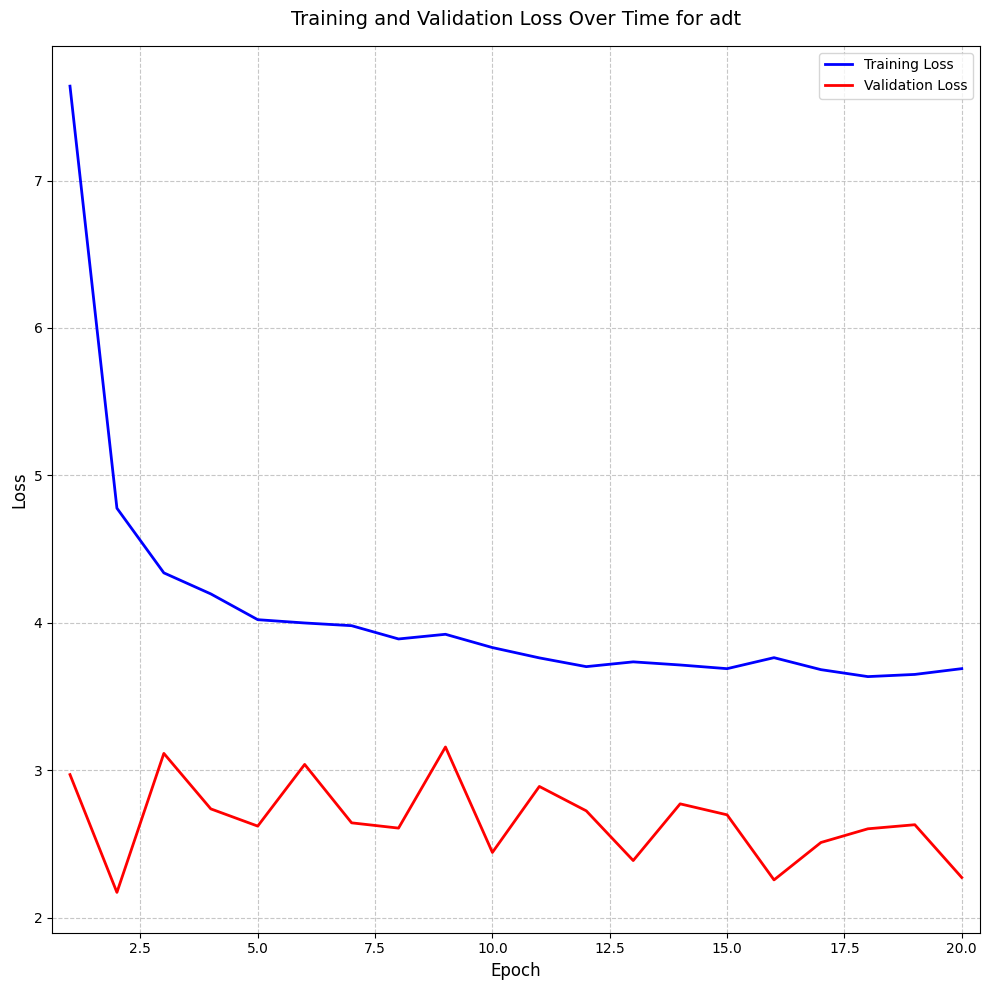

In [ ]:

plot_training_history(vae_model.per_epoch_adt_loss, vae_model.per_epoch_validation_adt_loss, title='Training and Validation Loss Over Time for adt', label1 = 'Training Loss', label2='Validation Loss')


The chart above plots the training and validation loss for ADT. The model is trained on 80% of the data and evaluated on 20% of the data.

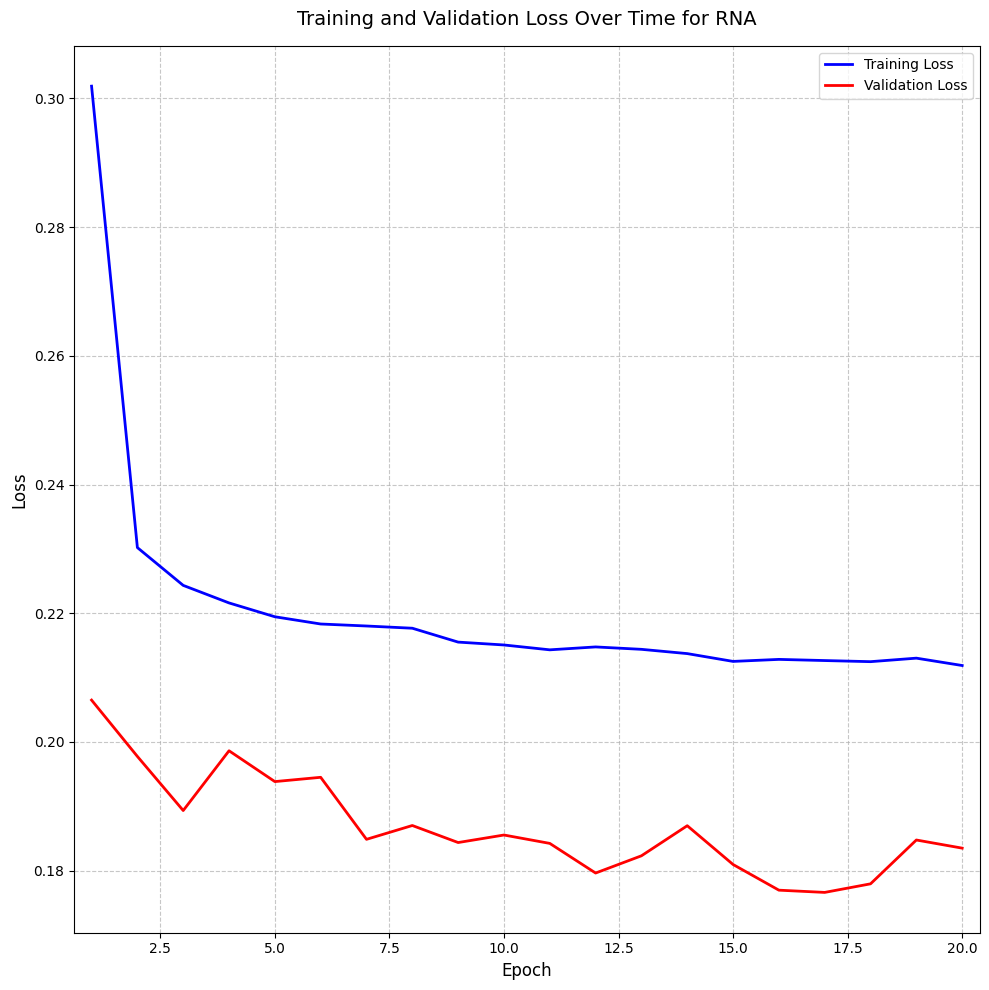

In [ ]:
plot_training_history(vae_model.per_epoch_rna_loss, vae_model.per_epoch_validation_rna_loss, title='Training and Validation Loss Over Time for RNA', label1 = 'Training Loss', label2='Validation Loss')

The chart above plots the training and validation loss for ADT. The model is trained on 80% of the data and evaluated on 20% of the data.

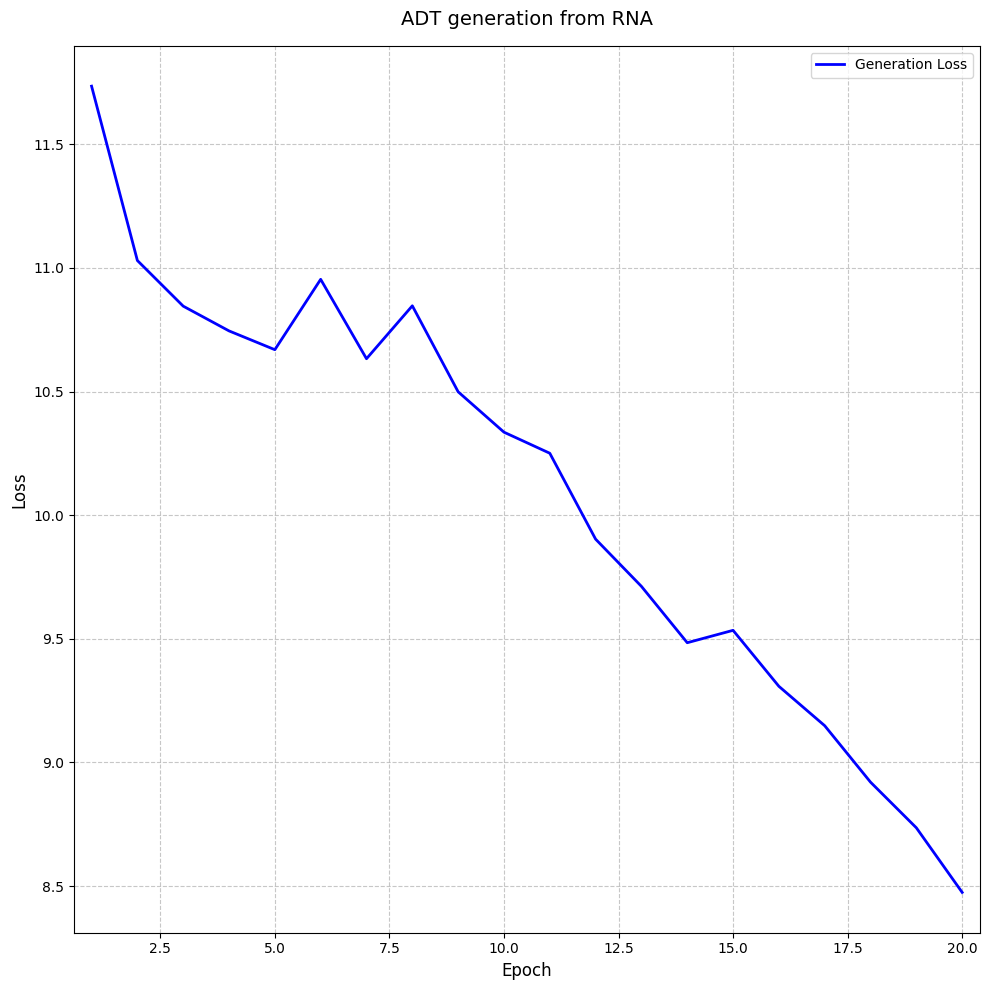

In [ ]:

plot_training_history(vae_model.per_epoch_adt_eval_loss, None, title='ADT generation from RNA', label1 = 'Generation Loss')

In the chart above, we track the model's perfomance when given RNA data to predict ADT. According to the chart, the model is able to learn and predict ADT, although the learning rate is slow.

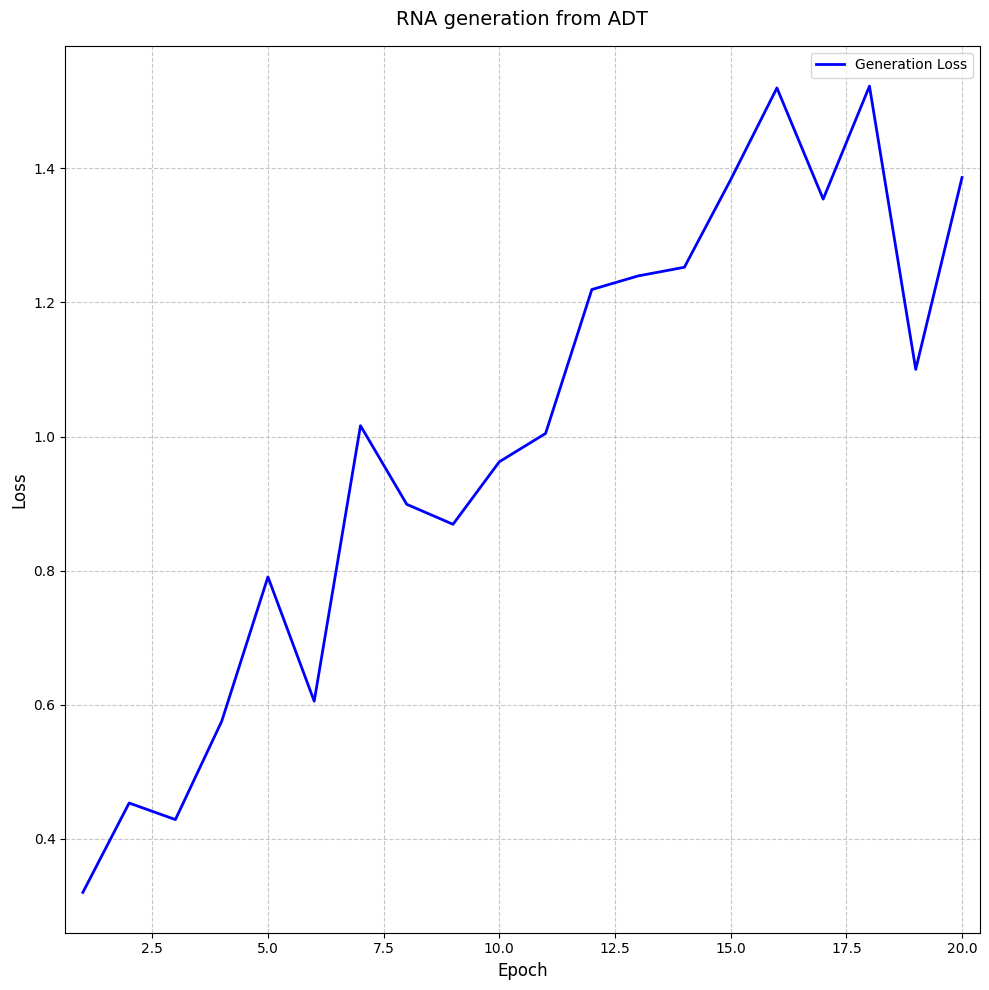

In [ ]:
plot_training_history(vae_model.per_epoch_rna_eval_loss, None, title='RNA generation from ADT', label1 = 'Generation Loss')

The chart above indicates that our model doesn't predict RNA well given ADT data as indicated by the increase in learning rate over epochs.

### Conclusion

This project gave us insights on how neural network models are built and designed. Our goal was to create a encoder-decoder (multimodal) model that would be able to predict RNA given ADT data, and ADT data from RNA. While the model performance indicates it appreciates both RNA and ADT data, it was interesting to see how the learning rate for RNA generation from ADT increasing as the epochs increase (struggles to learn when generating RNA data from ADT). This could explain why validation loss for ADT is not great (model is overfitting).

We need to go back and revise our model and its structure to understand why the learning rate is increasing.